In [32]:
import pymc3 as pm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import arviz as az

In [33]:
dfcov = pd.read_csv('global_25032020.csv')
#dfit = dfcov.loc[dfcov.country == 'Italy'].copy()

In [34]:
dfcov

,time,country,cum_confirm,cum_heal,cum_dead,mindata,elapsed
0,2020-02-24,Afghanistan,1,0,0,2020-02-24,0.0
1,2020-02-25,Afghanistan,1,0,0,2020-02-24,1.0
2,2020-02-26,Afghanistan,1,0,0,2020-02-24,2.0
3,2020-02-27,Afghanistan,1,0,0,2020-02-24,3.0
4,2020-02-28,Afghanistan,1,0,0,2020-02-24,4.0
5,2020-02-29,Afghanistan,1,0,0,2020-02-24,5.0
6,2020-03-01,Afghanistan,1,0,0,2020-02-24,6.0
7,2020-03-02,Afghanistan,1,0,0,2020-02-24,7.0
8,2020-03-03,Afghanistan,1,0,0,2020-02-24,8.0
9,2020-03-04,Afghanistan,1,0,0,2020-02-24,9.0


# Modelo SIR - Itália

In [39]:
dfit = dfcov.loc[dfcov.country == 'Italy'].copy()

In [79]:
# População total da Itália em 2019
# OBS: não sei se é razoável usar o total da população
# As proporções vão ficar bem próxima de 0
N = 60550075
N = 100000

Preparando os dados

In [80]:
dfit.sort_values('time', ascending = False)
dfit['confirm'] = dfit.cum_confirm.diff(1)
dfit['heal'] = dfit.cum_heal.diff(1)
dfit['dead'] = dfit.cum_dead.diff(1)
dfit = dfit.fillna(0)
dfit['pconfirm'] = dfit.cum_confirm / N
dfit['prec'] = (dfit.cum_heal + dfit.cum_dead) / N

Casos novos por dia

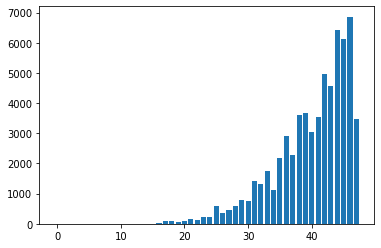

In [81]:
plt.bar(x = dfit.elapsed, height = dfit.confirm)
plt.show()

Modelo

In [98]:
from pymc3.ode import DifferentialEquation
# beta = número de contatos diários por infectado
# pcont - probabilidade de contágio
# gamma - proporção de doentes que se recuperam ou morrem em um dia

def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    return [ds, di]

times = dfit.elapsed.values / dfit.elapsed.values.max()

sir_model = DifferentialEquation(
    func=SIR,
    times=times,
    n_states=2,
    n_theta=2,
    t0=0,
)

Resolvendo o modelo

In [100]:
c0 = dfit.pconfirm.min() / N
s0 = 1 - c0
yobs = np.stack([1-dfit.pconfirm.values-dfit.prec.values, dfit.pconfirm.values], axis = 0).T

In [ ]:
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,3)
    lam = pm.Lognormal('lambda',pm.math.log(2),2)
    beta = pm.Deterministic('beta', lam*R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed= yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000,tune=1000, target_accept=0.9, cores=8)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [lambda, R0, sigma]
 77%|███████▋  | 12359/16000 [12:42<03:45, 16.12it/s]